In [1]:
# Fit notebook to browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import ROOT
import math 
import time
import os
import numpy as np
from array import array
import uproot
import pandas as pd

Welcome to JupyROOT 6.22/02


In [3]:
# Get input TTree
dir_base = '/grid_mnt/vol_home/llr/cms/portales/HIGtrigger/higgs-trigger-nanoaod/CMSSW_10_6_18/src/'
dir_in = dir_base + 'higgs-trigger-nano/'

DFs = {}

file_in = dir_in + 'ntuple_24comb_muon.root'
#file_in = dir_in + 'histos_24B_Muon.v1.root'
the_tree = uproot.open(file_in)['VBFNanoAOD/VBFtree']
df = ROOT.RDataFrame('VBFNanoAOD/VBFtree',file_in)

runBC     ='run>=379786 && run<380266'
runDpre   ='run>=380266 && run<380647'
runDEpost ='run>=380647'

DFs['BC']     = df.Filter(runBC)
DFs['Dpre']   = df.Filter(runDpre)
DFs['DEpost'] = df.Filter(runDEpost)



Error in <TList::Clear>: A list is accessing an object (0x5608e6589140) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x5608e65acc30) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x5608e65ad040) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x5608e65ad410) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x5608e65ad8e0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x5608e65af420) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x5608e65afe10) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x5608e65b0040) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x5608e65b04a0) already deleted (list name = TList)
Error in <TList::Clear>: A l

In [4]:
# highest mjj among all jet pairs (with pT>60 GeV, id tight) + additional variables for VBF jets
ROOT.gInterpreter.Declare('''
float get_VBF_var(TString var,
                  ROOT::VecOps::RVec<Float_t> pt,
                  ROOT::VecOps::RVec<Float_t> eta,
                  ROOT::VecOps::RVec<Float_t> phi,
                  ROOT::VecOps::RVec<Float_t> id,
                  ROOT::VecOps::RVec<Float_t> chf,
                  ROOT::VecOps::RVec<Float_t> rawfactor,
                  Float_t pt1cut,
                  Float_t pt2cut,
                  Float_t idcut,
                  Bool_t applyRawFactor) {
    
    Double_t mjj      = -1;
    Double_t detajj   = -1;
    Double_t etabest  = -999;
    Double_t etabest2 = -999;
    Double_t ptbest  = -999;
    Double_t ptbest2 = -999;
    Double_t chfbest  = -1;
    Double_t chfbest2 = -1;
    
    const auto size = pt.size();
    for (size_t idx1=0; idx1<size; ++idx1){
        for (size_t idx2=0; idx2<idx1; ++idx2){
        
            // VBF jets have to pass the ptcut2
            if (pt[idx1]<pt2cut || pt[idx2]<pt2cut)
                continue;
                           
            // in any case, we want tightly ID'd jets (just a safety, the condition should never be true)
            if (id[idx1]<idcut || id[idx2]<idcut)
                continue;
            
            // if minimal selection applies, get thtPt
            ROOT::Math::PtEtaPhiMVector p1,p2;
            if(!applyRawFactor){
                p1.SetPt(pt[idx1]).SetEta(eta[idx1]).SetPhi(phi[idx1]).SetM(0.);
                p2.SetPt(pt[idx2]).SetEta(eta[idx2]).SetPhi(phi[idx2]).SetM(0.);
            } else {
                p1.SetPt(pt[idx1]*(1.-rawfactor[idx1])).SetEta(eta[idx1]).SetPhi(phi[idx1]).SetM(0.);
                p2.SetPt(pt[idx2]*(1.-rawfactor[idx2])).SetEta(eta[idx2]).SetPhi(phi[idx2]).SetM(0.);
            }
            // check if the pair has best mjj, if so store VBF jets quantities
            if ((p1+p2).mass() > mjj) {
                mjj      = (p1+p2).mass();
                detajj   = abs(eta[idx1]-eta[idx2]);
                etabest  = (p1.pt()>p2.pt()) ? p1.eta():p2.eta();
                etabest2 = (p1.pt()>p2.pt()) ? p2.eta():p1.eta();
                ptbest   = (p1.pt()>p2.pt()) ? p1.pt():p2.pt();
                ptbest2  = (p1.pt()>p2.pt()) ? p2.pt():p1.pt();
                chfbest  = (p1.pt()>p2.pt()) ? chf[idx1]:chf[idx2];
                chfbest2 = (p1.pt()>p2.pt()) ? chf[idx2]:chf[idx1];
            }
        }
    }
    if (var=="mjj") 
        return mjj;
    if (var=="detajj")
        return detajj;
    if (var=="eta")
        return etabest;
    if (var=="eta2")
        return etabest2;
    if (var=="pt")
        return ptbest;
    if (var=="pt2")
        return ptbest2;
    if (var=="chf")
        return chfbest;
    if (var=="chf2")
        return chfbest2;
        
    return -999.;
}
'''
)

True

In [5]:
# highest mjj among all jet pairs (with pT>60 GeV, id tight) + additional variables for VBF jets
ROOT.gInterpreter.Declare('''
float get_mjj_dumb(TString var,
                  ROOT::VecOps::RVec<Float_t> pt,
                  ROOT::VecOps::RVec<Float_t> eta,
                  ROOT::VecOps::RVec<Float_t> phi) {
    
            ROOT::Math::PtEtaPhiMVector pp1(pt[0], eta[0], phi[0], 0.);
            ROOT::Math::PtEtaPhiMVector pp2(pt[1], eta[1], phi[1], 0.);
            return (pp1+pp2).mass();
}
'''
)

True

In [6]:
def fill_eff(h_num, h_den, year,var,version):
    eff = ROOT.TGraphAsymmErrors(h_num[year][var][version].GetValue(),
                                 h_den[year][var].GetValue(),
                                 'eff_{}'.format(var))
    return eff

def redrawBorder():
    ROOT.gPad.Update()
    ROOT.gPad.RedrawAxis()
    l = ROOT.TLine()
    l.SetLineWidth(2)
    l.DrawLine(ROOT.gPad.GetUxmin(), ROOT.gPad.GetUymax(), ROOT.gPad.GetUxmax(), ROOT.gPad.GetUymax())
    l.DrawLine(ROOT.gPad.GetUxmax(), ROOT.gPad.GetUymin(), ROOT.gPad.GetUxmax(), ROOT.gPad.GetUymax())
    l.DrawLine(ROOT.gPad.GetUxmin(), ROOT.gPad.GetUymin(), ROOT.gPad.GetUxmin(), ROOT.gPad.GetUymax())
    l.DrawLine(ROOT.gPad.GetUxmin(), ROOT.gPad.GetUymin(), ROOT.gPad.GetUxmax(), ROOT.gPad.GetUymin())

def print_unique_runs(df):
    df_runs = df.AsNumpy(["run"])
    np.unique(df_runs['run'])
    for run in np.unique(df_runs['run']):
        nevts = df.Filter('run=={} && passL1VBFincl'.format(run)).Count().GetValue()
        if nevts==0:
            print(int(run))

In [7]:
print_unique_runs(DFs['pre'])

In [8]:
def print_unique_runs2(df):
    df_runs = df.AsNumpy(["run"])
    np.unique(df_runs['run'])
    for run in np.unique(df_runs['run']):
        nevts = df.Filter('run=={} && (passL1VBFincl||passL1VBFjets||passL1VBFmet||passL1VBFmu||passL1VBFele||passL1VBFtau)'.format(run)).Count().GetValue()
        if nevts==0:
            print(int(run))
            
print_unique_runs2(DFs['post'])

In [7]:
periods = ["BC","Dpre","DEpost"]

#pt1cut = 125.
#pt2cut = 50.
#mjjcut = 1100.
#detajjcut = 4.0

pt1cut = 135.
pt2cut = 60.
mjjcut = 1500.

pt1cut = 155.
pt2cut = 60.
mjjcut = 1500.

idcut = 6

df_mjj_all = {}

# apply basic filter & evaluate variables
for year in periods:
    
    cut_df = DFs[year]    
    
    df_mjj_all[year] = cut_df\
                    .Define('mjj2',    'get_VBF_var( "mjj", jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,jets_rawfactor,{},{},{},0)'.format(pt1cut,pt2cut,idcut))\
                    .Define('mjj2raw',    'get_VBF_var( "mjj", jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,jets_rawfactor,{},{},{},1)'.format(pt1cut,pt2cut,idcut))\
                    .Define('mjjdumb', 'get_mjj_dumb("",jets_pt,jets_eta,jets_phi)')\
                    .Define('chfbest', 'get_VBF_var( "chf", jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,jets_rawfactor,{},{},{},0)'.format(pt1cut,pt2cut,idcut))\
                    .Define('chfbest2','get_VBF_var( "chf2",jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,jets_rawfactor,{},{},{},0)'.format(pt1cut,pt2cut,idcut))\
                    .Define('etabest', 'get_VBF_var( "eta", jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,jets_rawfactor,{},{},{},0)'.format(pt1cut,pt2cut,idcut))\
                    .Define('etabest2','get_VBF_var( "eta2",jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,jets_rawfactor,{},{},{},0)'.format(pt1cut,pt2cut,idcut))\
                    .Define('ptbest',  'get_VBF_var( "pt",  jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,jets_rawfactor,{},{},{},0)'.format(pt1cut,pt2cut,idcut))\
                    .Define('ptbest2', 'get_VBF_var( "pt2", jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,jets_rawfactor,{},{},{},0)'.format(pt1cut,pt2cut,idcut))\
                    .Define('ptj1',  'jets_pt[0]')\
                    .Define('ptj2', 'jets_pt[1]')\
                    .Define('pt1raw',  'jets_pt[0]*(1.-jets_rawfactor[0])')\
                    .Define('pt2raw', 'jets_pt[1]*(1.-jets_rawfactor[1])')\
                    .Define('Detajj',  'abs(etabest-etabest2)')

In [10]:
veto_runs = [378994,378997,379000,379001,379002,379004,379006,379008,379009,379010,379315,379316,379317,379318,379337]

In [11]:
### VBF inclusive trigger plots

df_den = {}#df_mjj_all
df_num = {}#df_mjj_all
df_base = {}
for year in periods:
    print('Filling dfs for {}'.format(year))
    df_den[year] = {}
    
    df_base[year] = df_mjj_all[year]
    for run in veto_runs:
        df_base[year] = df_base[year].Filter('run!={}'.format(run))#.Filter('Detajj>4.0')
    
    df_den[year]['mjj'] = df_base[year].Filter('jets_pt[0]>{} && jets_pt[1]>{}'.format(pt1cut,pt2cut))
    df_den[year]['mjjraw'] = df_base[year].Filter('jets_pt[0]*(1.-jets_rawfactor[0])>{} && jets_pt[1]*(1.-jets_rawfactor[1])>{}'.format(pt1cut,pt2cut))
    df_den[year]['pt1'] = df_base[year].Filter('mjj2>{} && jets_pt[1]*(1.-jets_rawfactor[1])>{}'.format(mjjcut,pt2cut))
    df_den[year]['pt2'] = df_base[year].Filter('mjj2>{} && jets_pt[0]*(1.-jets_rawfactor[0])>{}'.format(mjjcut,pt1cut))
    df_den[year]['pt1raw'] = df_base[year].Filter('mjj2raw>{} && jets_pt[1]*(1.-jets_rawfactor[1])>{}'.format(mjjcut,pt2cut))
    df_den[year]['pt2raw'] = df_base[year].Filter('mjj2raw>{} && jets_pt[0]*(1.-jets_rawfactor[0])>{}'.format(mjjcut,pt1cut))
    
    
    df_num[year] = { 'mjj' : {}, 'pt1' : {}, 'pt2' : {},
                     'mjjraw' : {}, 'pt1raw' : {}, 'pt2raw' : {}}
    
    df_num[year]['mjj']['new'] = df_den[year]['mjj'].Filter('passVBFincl_2j || passVBFincl_3j')
    df_num[year]['mjj']['L1']  = df_den[year]['mjj'].Filter('passL1VBFincl')
    
    df_num[year]['pt1']['new'] = df_den[year]['pt2'].Filter('passVBFincl_2j || passVBFincl_3j')
    df_num[year]['pt1']['L1']  = df_den[year]['pt2'].Filter('passL1VBFincl')
    
    df_num[year]['pt2']['new'] = df_den[year]['pt2'].Filter('passVBFincl_2j || passVBFincl_3j')
    df_num[year]['pt2']['L1']  = df_den[year]['pt2'].Filter('passL1VBFincl')
    
    
    
    df_num[year]['mjjraw']['new'] = df_den[year]['mjjraw'].Filter('passVBFincl_2j || passVBFincl_3j')
    df_num[year]['mjjraw']['L1']  = df_den[year]['mjjraw'].Filter('passL1VBFincl')
    
    df_num[year]['pt1raw']['new'] = df_den[year]['pt2raw'].Filter('passVBFincl_2j || passVBFincl_3j')
    df_num[year]['pt1raw']['L1']  = df_den[year]['pt2raw'].Filter('passL1VBFincl')
    
    df_num[year]['pt2raw']['new'] = df_den[year]['pt2raw'].Filter('passVBFincl_2j || passVBFincl_3j')
    df_num[year]['pt2raw']['L1']  = df_den[year]['pt2raw'].Filter('passL1VBFincl')



#hist from DF    
h_den = {}
h_num = {}

#nbin=10
#nbin=15
nbin=25
import time
for year in periods:
    print('Filling histograms for {}'.format(year))
    time_start = time.time()
    
    h_num[year] = {'mjj' : {}, 'pt1' : {}, 'pt2' : {},
                   'mjjraw' : {}, 'pt1raw' : {}, 'pt2raw' : {}}
    h_den[year] = {}
    
    h_den[year]['mjj'] = df_den[year]['mjj'].Histo1D(    ('h_den','',   nbin,0,2500),'mjj2')
    h_num[year]['mjj'] = {
        'new': df_num[year]['mjj']['new'].Histo1D(    ('h_num_new','',   nbin,0,2500),'mjj2'),
        'L1':  df_num[year]['mjj']['L1'].Histo1D(     ('h_num_l1','',    nbin,0,2500),'mjj2'),
    }
    
    h_den[year]['pt1'] = df_den[year]['pt1'].Histo1D(    ('h_den','',   nbin,0,300),'ptj1')
    h_num[year]['pt1'] = {
        'new': df_num[year]['pt1']['new'].Histo1D(    ('h_num_new','',   nbin,0,300),'ptj1'),
        'L1':  df_num[year]['pt1']['L1'].Histo1D(     ('h_num_l1','',    nbin,0,300),'ptj1'),
    }
    
    h_den[year]['pt2'] = df_den[year]['pt2'].Histo1D(    ('h_den','',   nbin,0,200),'ptj2')
    h_num[year]['pt2'] = {
        'new': df_num[year]['pt2']['new'].Histo1D(    ('h_num_new','',   nbin,0,200),'ptj2'),
        'L1':  df_num[year]['pt2']['L1'].Histo1D(     ('h_num_l1','',    nbin,0,200),'ptj2'),
    }
        
    h_den[year]['mjjraw'] = df_den[year]['mjjraw'].Histo1D(    ('h_den','',   nbin,0,2500),'mjj2')
    h_num[year]['mjjraw'] = {
        'new': df_num[year]['mjjraw']['new'].Histo1D(    ('h_num_new','',   nbin,0,2500),'mjj2'),
        'L1':  df_num[year]['mjjraw']['L1'].Histo1D(     ('h_num_l1','',    nbin,0,2500),'mjj2'),
    }
    
    h_den[year]['pt1raw'] = df_den[year]['pt1raw'].Histo1D(    ('h_den','',   nbin,0,300),'ptj1')
    h_num[year]['pt1raw'] = {
        'new': df_num[year]['pt1raw']['new'].Histo1D(    ('h_num_new','',   nbin,0,300),'ptj1'),
        'L1':  df_num[year]['pt1raw']['L1'].Histo1D(     ('h_num_l1','',    nbin,0,300),'ptj1'),
    }
    
    h_den[year]['pt2raw'] = df_den[year]['pt2raw'].Histo1D(    ('h_den','',   nbin,0,200),'ptj2')
    h_num[year]['pt2raw'] = {
        'new': df_num[year]['pt2raw']['new'].Histo1D(    ('h_num_new','',   nbin,0,200),'ptj2'),
        'L1':  df_num[year]['pt2raw']['L1'].Histo1D(     ('h_num_l1','',    nbin,0,200),'ptj2'),
    }
    
print("all histo filled")

Filling dfs for BC
Filling dfs for Dpre
Filling dfs for DEpost
Filling histograms for BC
Filling histograms for Dpre
Filling histograms for DEpost
all histo filled


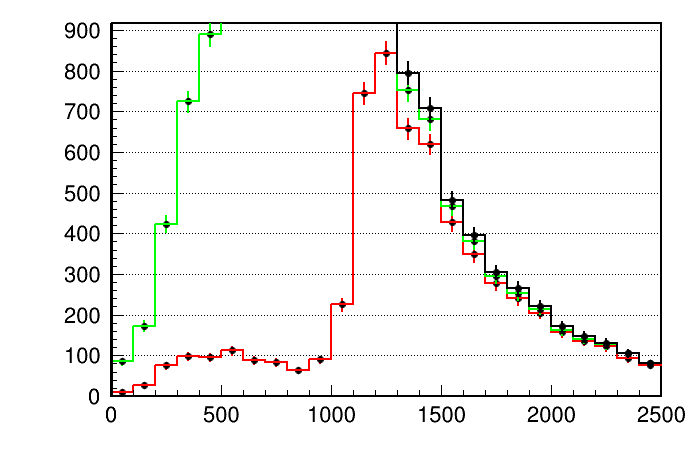

In [17]:
ctest = ROOT.TCanvas("test","test")
ctest.cd()

# hlt histo first to "zoom in"
h_num["pre"]["mjj"]['new'].SetLineColor(2)
h_num["pre"]["mjj"]['new'].Draw("hist e")

# then L1
h_num["pre"]["mjj"]['L1'].SetLineColor(3)
h_num["pre"]["mjj"]['L1'].Draw("hist e same")

# then denominator
h_den["pre"]["mjj"].Draw("hist e same")


#ctest.SetLogy()
ctest.SetGridy()
ctest.Draw()


In [ ]:
#periods = ['23all','23mc','23C']
#periods = ['pre','post']
periods = ["BC","Dpre","DEpost"]

#periods = ['24B']
Eff = {}
for year in periods:
    print('Evaluating efficiencies for {}'.format(year))
    Eff[year] = {'mjj' : {}, 'pt1' : {}, 'pt2' : {},
                   'mjjraw' : {}, 'pt1raw' : {}, 'pt2raw' : {}}
    
    Eff[year]['mjj']['new']    = fill_eff(h_num, h_den, year, 'mjj', 'new')
    Eff[year]['mjj']['L1']     = fill_eff(h_num, h_den, year, 'mjj', 'L1' )
    
    #Eff[year]['pt1']['new']    = fill_eff(h_num, h_den, year, 'pt1', 'new')
    #Eff[year]['pt1']['L1']     = fill_eff(h_num, h_den, year, 'pt1', 'L1' )
    
    #Eff[year]['pt2']['new']    = fill_eff(h_num, h_den, year, 'pt2', 'new')
    #Eff[year]['pt2']['L1']     = fill_eff(h_num, h_den, year, 'pt2', 'L1' )
    
    #Eff[year]['mjjraw']['new']    = fill_eff(h_num, h_den, year, 'mjjraw', 'new')
    #Eff[year]['mjjraw']['L1']     = fill_eff(h_num, h_den, year, 'mjjraw', 'L1' )
    
    #Eff[year]['pt1raw']['new']    = fill_eff(h_num, h_den, year, 'pt1raw', 'new')
    #Eff[year]['pt1raw']['L1']     = fill_eff(h_num, h_den, year, 'pt1raw', 'L1' )
    
    #Eff[year]['pt2raw']['new']    = fill_eff(h_num, h_den, year, 'pt2raw', 'new')
    #Eff[year]['pt2raw']['L1']     = fill_eff(h_num, h_den, year, 'pt2raw', 'L1' )

In [19]:
# Definingvariables, categories & cuts

jet_vars = ['pt1','pt2','mjj','detajj','chf']

trigs = ['VBFincl','VBFjets','VBFmet' ,'VBFphot','VBFele' ,'VBFmu'  ,'VBFtau']


add_cut_label = {
    'mjj'    : ' ',
    'pt1' : 'm_{jj} > %.0f GeV' % (mjjcut),
    'pt2' : 'm_{jj} > %.0f GeV' % (mjjcut),
    'mjjraw'    : ' ',
    'pt1raw' : 'm_{jj} > %.0f GeV' % (mjjcut),
    'pt2raw' : 'm_{jj} > %.0f GeV' % (mjjcut),
}

# Plotting labels
VARLABELS = {
    'mjj'    : 'm_{jj} [GeV]',
    'pt1'    : 'Leading jet p_{T} [GeV]',
    'pt2'    : 'Subleading jet p_{T} [GeV]',    
    'mjjraw'    : 'm_{jj} [GeV]',
    'pt1raw'    : 'Leading jet p_{T} [GeV]',
    'pt2raw'    : 'Subleading jet p_{T} [GeV]',    
}

import CMS_lumi, tdrstyle
import array

tdrstyle.setTDRStyle()

#change the CMS_lumi variables (see CMS_lumi.py)
CMS_lumi.writeExtraText = True
CMS_lumi.extraText = "Preliminary"
#CMS_lumi.lumi_sqrtS = "22.1 fb^{-1}, 2023 (13.6 TeV)" # used with iPeriod = 0, e.g. for simulation-only plots (default is an empty string)
CMS_lumi.lumi_sqrtS = "2024D (13.6 TeV)" # used with iPeriod = 0, e.g. for simulation-only plots (default is an empty string)

iPeriod = 0
iPos = 0#11
H_ref = 600; 
W_ref = 600; 
W = W_ref
H = H_ref
# references for T, B, L, R
T = 0.08*H_ref
B = 0.14*H_ref 
L = 0.12*W_ref
R = 0.04*W_ref



Error in <TList::Clear>: A list is accessing an object (0x56112d66fff0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x56112d670400) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x56112d6707d0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x56112d6731d0) already deleted (list name = TList)


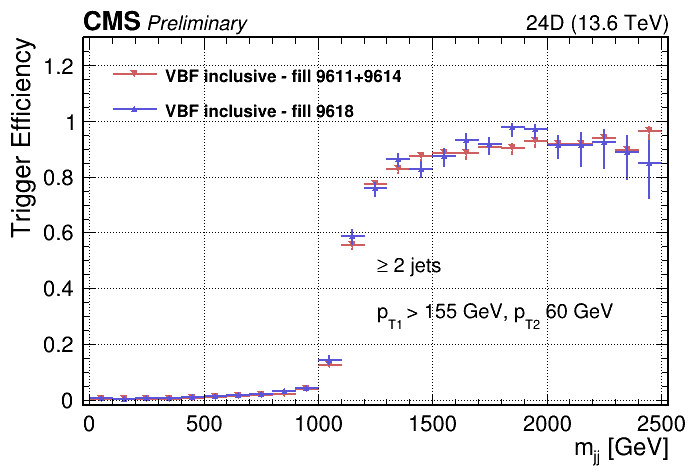

In [20]:
#######################################
### L1 2023 vs 2024
#######################################

CMS_lumi.lumi_sqrtS = "24D (13.6 TeV)" # used with iPeriod = 0, e.g. for simulation-only plots (default is an empty string)
theVar = 'mjj'

path = {}
canvas = {}
hpx = {}
legend = {}
#for theVar in ['mjj','detajj','MET']:
text_coord = {
    'mjj' :    [1200,0.04,2400,0.57],
    'pt1' :    [100,0.1,240,0.7],
    'pt2' :    [100,0.1,240,0.7],
    'mjjraw' :    [1200,0.04,2400,0.57],
    'pt1raw' :    [100,0.1,240,0.7],
    'pt2raw' :    [100,0.1,240,0.7],
    'detajj' : [4.1,0.07,7.95,0.6],
    'MET' :    [170,0.04,390,0.64],
    'chf' :    [0.45,0.04,0.92,0.64]
    
}


Eff['pre'][theVar]['new'].SetLineColor(46)
Eff['pre'][theVar]['new'].SetMarkerColor(46)
Eff['pre'][theVar]['new'].SetLineWidth(2)
Eff['pre'][theVar]['new'].SetMarkerStyle(23)   

Eff['post'][theVar]['new'].SetLineColor(9)
Eff['post'][theVar]['new'].SetMarkerColor(9)
Eff['post'][theVar]['new'].SetLineWidth(2)
Eff['post'][theVar]['new'].SetMarkerStyle(22)   

path['pre'] = ROOT.TPaveText(text_coord[theVar][0],
                              text_coord[theVar][1],
                              text_coord[theVar][2],
                              text_coord[theVar][3])

path['pre'].SetTextAlign(12)
path['pre'].SetFillStyle(0)
path['pre'].SetBorderSize(0)

#path['pre'].AddText('#geq 2 jets, #Delta#eta_{jj}>4.0')
path['pre'].AddText('#geq 2 jets')
path['pre'].AddText('p_{T1} > %.0f GeV, p_{T2} %.0f GeV ' % (pt1cut,pt2cut)) 
path['pre'].AddText(add_cut_label[theVar])

canvas['pre']=ROOT.TCanvas('pre',"Trigger Efficicency")
canvas['pre'].SetFillColor(0)
canvas['pre'].SetBorderMode(0)
canvas['pre'].SetFrameFillStyle(0)
canvas['pre'].SetFrameBorderMode(0)
canvas['pre'].SetLeftMargin( L/W )
canvas['pre'].SetRightMargin( R/W )
canvas['pre'].SetTopMargin( T/H )
canvas['pre'].SetBottomMargin( B/H )
canvas['pre'].SetTickx()
canvas['pre'].SetTicky()
canvas['pre'].SetGrid()
canvas['pre'].cd()

#dummy hist for consistent display
xlow=Eff['pre'][theVar]['new'].GetXaxis().GetBinLowEdge(0)
xhigh=Eff['pre'][theVar]['new'].GetXaxis().GetBinUpEdge(92)
hpx['pre'] = ROOT.TH2F("hpx","",10,xlow,xhigh,10,-0.02,1.3)
hpx['pre'].SetStats(False)
hpx['pre'].SetTitle(theVar)
hpx['pre'].GetXaxis().SetTitle(VARLABELS[theVar])
hpx['pre'].GetYaxis().SetTitle("Trigger Efficiency")
hpx['pre'].GetXaxis().SetTitleSize(0.055)
hpx['pre'].GetXaxis().SetTitleOffset(1.1)
hpx['pre'].GetYaxis().SetTitleSize(0.06)
hpx['pre'].GetYaxis().SetTitleOffset(0.9)
hpx['pre'].Draw()

legend['pre'] = ROOT.TLegend(0.15,0.73,0.5,0.88) # top left
legend['pre'].SetTextSize(0.04)
legend['pre'].SetFillStyle(0)
legend['pre'].SetBorderSize(0)
legend['pre'].AddEntry(Eff['pre'][theVar]['new'],   'VBF inclusive - fill 9611+9614',    'lp')
legend['pre'].AddEntry(Eff['post'][theVar]['new'],  'VBF inclusive - fill 9618','lp')

path['pre'].SetTextSize(0.045);

Eff['pre'][theVar]['new'].Draw("p same")
Eff['post'][theVar]['new'].Draw("p same")

legend['pre'].Draw("same")
path['pre'].Draw("same")
canvas['pre'].Update()
CMS_lumi.CMS_lumi(canvas['pre'], iPeriod, iPos)

redrawBorder()

#canvas[theVar].Draw()
canvas['pre'].Draw()

canvas['pre'].SaveAs(dir_in + "/plots/VBFincl_HEHF24D_{}.20240515.pdf".format(theVar))
canvas['pre'].SaveAs(dir_in + "/plots/VBFincl_HEHF24D_{}.20240515.png".format(theVar))
canvas['pre'].SaveAs(dir_in + "/plots/VBFincl_HEHF24D_{}.20240515.root".format(theVar))